In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
#-------------------------------------------------------------------------------
# Here you need to list your subprocesses, i.e. those processes you have in
# your foreground in openlca. Use the list below as an example.
#-------------------------------------------------------------------------------
sub_process_names = [
    'Leaching',
    'Solution purification',
    'Mn recovery',
    'Co recovery',
    'Ni recovery',
    'Li recovery',
    'Effluent treatment'
]

In [52]:
#-------------------------------------------------------------------------------
# Here you need to state the name of your scenario.
# OBS!!! You need to have this name in the beginning of each your subprocesses
# in openLCA! Otherwise the code will not work.
#
# For example, in openLCA, your connected FG processes should be named like
# 'Baseline - Leaching'
# 'Baseline - Solution purification'
# 'Baseline - Mn recovery'
# ...
#-------------------------------------------------------------------------------
scenario = 'Baseline'

In [5]:
%%capture
# Read the contribution tree file
df = pd.read_excel('contribution_tree.xlsx', 'Upstream tree')

In [55]:
# Extract and parse the impact category name and unit
category_split = df.columns[0].split(':')           # Get the category
category = ','.join(category_split[1:])[1:]         # Parse the category
unit = df.iloc[0][8]                                # Get the unit
unit = unit[unit.find('['):unit.find(']')+1]        # Parse the unit
impact_category = ''.join([category, ' ', unit])    # Join the category and unit
impact_category

'Human toxicity, carcinogenic, inorganics [CTUh]'

In [71]:
# Parse the raw data to exclude lower levels from upstream flows

# Initialize variables
processes = []
final_rows = []
process_levels = []
previous_levels = []
previous_level = 0

# Iterate through the rows in the dataframe
for i,row in df.iterrows():
    # Replace 'nan' values by 0 in the 'Direct contributions' column
    if pd.isna(row.iloc[-1]):
        row.iloc[-1] = 0
    
    # Determine the level by checking which cell is filled in the row
    level = next((j for j in range(len(row)) if not pd.isna(row[j])), len(row))
    
    # Check if we are staying on the same level
    if level == previous_level:
        # Staying on the same level

        # Check if the current row is a subprocess
        if row[level].startswith(scenario):
            # Keep the row
            process_levels.append(level)
            row['Level'] = level
            final_rows.append(row.dropna().values)

        # Check if the previous level is a subprocess, i.e. the current row is a
        # direct child of a subprocess
        elif process_levels and (previous_levels == process_levels[-1]):
            # Keep the row
            row['Level'] = level
            final_rows.append(row.dropna().values)

        # Otherwise, discard the row (do nothing)

    # Check if we are going to a lower level
    elif previous_levels and (level > previous_levels[-1]):
        # Going lower
        previous_levels.append(previous_level)
        
        # Check if the current row is a subprocess
        if row[level].startswith(scenario):
            # Keep the row
            process_levels.append(level)
            row['Level'] = level
            final_rows.append(row.dropna().values)
        
        # Check if the previous level is a subprocess, i.e. the current row is a
        # direct child of a subprocess
        elif process_levels and (previous_level == process_levels[-1]):
            # Keep the row
            row['Level'] = level
            final_rows.append(row.dropna().values)

        # Otherwise, discard the row (do nothing)

    # Check if we are going to a higher level
    elif level < previous_level:
        # Going higher
        previous_levels.pop(-1)

        # Update the current subprocess depth
        if level == process_levels[-1]:
            process_levels.pop(-1)

        # Check if the current row is a subprocess
        if row[level].startswith(scenario):
            # Keep the row
            process_levels.append(level)
            row['Level'] = level
            final_rows.append(row.dropna().values)

        # Check if the previous level is a subprocess, i.e. the current row is a
        # direct child of a subprocess
        elif previous_levels and process_levels and (previous_levels[-1] == process_levels[-1]):
            # Keep the row
            row['Level'] = level
            final_rows.append(row.dropna().values)

# df.head()
final_rows

[array(['Baseline - 7 Effluent treatment, substitution - RER',
        -8.985896524322624e-06, 0, 0], dtype=object)]

In [ ]:
def parse_contribution_tree(scenario):

    for i, row in df.iterrows():
        # Determine the level by checking which cell is filled in the row
        level = next((j for j in range(len(row)) if not pd.isna(row[j])), len(row))
        if level == current_subprocess_level:
            current_subprocess_level -= 1

        # Check if the current row is a subprocess
        if row[level].startswith(scenario):
            current_subprocess_level = level
            row['Level'] = level
            final_rows.append(row.dropna().values)

        # Check if the row is an activity and needs to be retained
        elif not pd.isna(row[level]):
            # Check if the activity is directly under a subprocess
            if level - 1 == current_subprocess_level:
                # Direct child of a subprocess
                row['Level'] = level
                final_rows.append(row.dropna().values)

    # Create a new DataFrame from the filtered rows
    final_rows[0][-1] = 'Level'
    final_df = pd.DataFrame(final_rows)
    final_df.columns = final_df.iloc[0]
    final_df = final_df[1:]

    return name, final_df

In [4]:
def parse_sub_processes(df, sub_process_names):
    sub_process_totals = []
    sub_processes = []

    # Extract sub-process 'totals' (e.g. 'Leaching')
    for i, row in df.iterrows():
        # print(row['Level'])
        # print(sub_process_names[7 - row['Level']])
        df.loc[i, 'Sub-process'] = sub_process_names[row['Level'] - 1]
        if row[0].startswith('Baseline'):
            sub_process_totals.append(row)
            df.drop(index=i, inplace=True)
    sub_process_totals = pd.DataFrame(sub_process_totals, columns=df.columns)
    
    # Group sub-processes
    for i, g in df.groupby('Level'):
        sub_processes.append(g)
    
    return sub_process_totals, sub_processes

In [5]:
def parse_process_names(processes):
    for p in processes:
        for i, row in p.iterrows():
            split_row = row[0].split(' | ')
            p.loc[i, 'Processes'] = split_row[0]
            if row[0].startswith('market for'):
                p.loc[i, 'Processes'] = row[0][11:]
            if row[0].startswith('market group for'):
                p.loc[i, 'Processes'] = row[0][17:]
            if row[0].endswith('production'):
                p.loc[i, 'Processes'] = row[0][:-11]

    return processes

In [6]:
def pop_col(indices, cols, new_cols):
    for i in indices:
        col = cols[i]
        new_cols.append(col)
        cols[i] = ''

    return cols, new_cols

In [7]:
def arrange_by_value(df):
    cols = df.columns
    negative = []
    positive = []

    for col in cols:
        if df[col].any() < 0:
            negative.append(col)
        else:
            positive.append(col)
    
    new_cols = positive + negative

    return new_cols

In [8]:
category, contributions = parse_contribution_tree('Baseline')
sub_process_totals, sub_processes = parse_sub_processes(contributions, sub_process_names)

c:\ProgramData\anaconda3\Lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [9]:
sub_processes[0]

,Processes,Result [CTUh],Direct contribution [CTUh],Level,Sub-process
2,"market for hazardous waste, for underground de...",0.0,0,1,Effluent treatment
3,"market group for electricity, medium voltage |...",0.0,0,1,Effluent treatment
4,"market for wastewater, average | wastewater, a...",0.0,0.0,1,Effluent treatment
5,"market for quicklime, milled, packed | quickli...",0.0,0,1,Effluent treatment
6,market group for tap water | tap water | Cutof...,0.0,0,1,Effluent treatment
7,"market for wastewater, unpolluted | wastewater...",0.0,0,1,Effluent treatment


In [11]:
sub_process_totals

,Processes,Result [CTUh],Direct contribution [CTUh],Level,Sub-process
1,"Baseline - 7 Effluent treatment, substitution ...",-8.985897e-06,0,0,NaN
8,"Baseline - 6 Li recovery, substitution - RER",-9.030844e-06,0,1,NaN
14,"Baseline - 5 Ni recovery, substitution - RER",-8.765403e-06,0,2,NaN
23,"Baseline - 4 Co recovery, substitution - RER",-2.252427e-06,0,3,NaN
24,"Baseline - 3 Mn recovery, substitution - RER",2.121432e-07,0,4,NaN
25,"Baseline - 2 Solution purification, substituti...",1.146591e-07,0,5,NaN
26,"Baseline - 1 Leaching, substitution - RER",1.027190e-07,0,6,NaN


In [12]:
category

'Human toxicity, carcinogenic, inorganics [CTUh]'

In [13]:
parsed = parse_process_names(sub_processes)

In [14]:
parsed[0]

,Processes,Result [CTUh],Direct contribution [CTUh],Level,Sub-process
2,"hazardous waste, for underground deposit",0.0,0,1,Effluent treatment
3,"electricity, medium voltage",0.0,0,1,Effluent treatment
4,"wastewater, average",0.0,0.0,1,Effluent treatment
5,"quicklime, milled, packed",0.0,0,1,Effluent treatment
6,tap water,0.0,0,1,Effluent treatment
7,"wastewater, unpolluted",0.0,0,1,Effluent treatment


In [15]:
combined_df = pd.concat(sub_processes)
combined_df = combined_df[::-1].reset_index(drop=True)

In [ ]:
pivot_df = combined_df.pivot(index='Sub-process', columns='Processes', values=combined_df.columns[1]).fillna(0)
pivot_df = pivot_df.reindex(index=combined_df['Sub-process'].unique(), columns=combined_df['Processes'].unique())

#-------------------------------------------------------------------------------
# Write all the processes you want to omit from the figure in the list below
#-------------------------------------------------------------------------------
dropped = [
    'nickel sulfate'
]

#-------------------------------------------------------------------------------
# Comment or uncomment the following line to plot all or only those w\o
#  'dropped'
#-------------------------------------------------------------------------------
# pivot_df.drop(['nickel sulfate', 'cobalt sulfate'], axis=1, inplace=True)

pivot_df

Processes,tap water,"electricity, medium voltage",sulfuric acid,"hydrogen peroxide, without water, in 50% solution state","copper concentrate, sulfide ore",hydrogen sulfide,"hazardous waste, for underground deposit","sodium hydroxide, without water, in 50% solution state",manganese sulfate,kerosene,...,"hazardous waste, for incineration",cobalt sulfate,Cyanex 272,nickel sulfate,lithium carbonate,"sodium sulfate, anhydrite","soda ash, dense","wastewater, unpolluted","quicklime, milled, packed","wastewater, average"
Sub-process,,,,,,,,,,,,,,,,,,,,,
Leaching,9.770914e-10,4.509357e-09,4.083175e-08,5.640082e-08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
Solution purification,2.136109e-10,1.340229e-08,0.000000e+00,1.029164e-12,-5.382026e-08,1.990384e-09,2.307165e-08,2.708141e-08,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
Mn recovery,1.340658e-10,8.350369e-09,6.038279e-09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.192043e-09,-2.096152e-08,3.627396e-09,...,5.404318e-08,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
Co recovery,1.799891e-10,7.187823e-09,6.390661e-09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.002328e-08,0.000000e+00,2.658210e-09,...,5.819872e-08,-0.000003,1.401727e-08,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
Ni recovery,3.731358e-10,5.614346e-09,1.963875e-08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.212516e-08,0.000000e+00,4.182558e-09,...,8.633381e-08,0.000000,0.000000e+00,-0.000007,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
Li recovery,4.022080e-10,1.979989e-08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000,0.000000e+00,0.000000,-3.047034e-07,-1.826448e-07,2.017052e-07,0.000000e+00,0.000000e+00,0.000000e+00
Effluent treatment,3.306377e-10,1.849581e-08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.368781e-08,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,2.983697e-10,9.353848e-10,1.199468e-09


In [17]:
#-------------------------------------------------------------------------------
# In this cell, the flows/processes will be rearranged so that positive values
#  will be first, and negative last.
#
# Alternatively, use the list 'indices' to define the order of columns (flows/
#  processes) in your legend manually.
#
# Run this cell to apply the changes and see the available indices, as well your
#  new list of flow/processes.
#
# Run the previous cell to reset the list variables.
#
# Run the next cell to plot the figure, and see the legend.
#-------------------------------------------------------------------------------

cols = pivot_df.columns.to_list()
used_cols = cols.copy()
new_cols = []

# new_cols = arrange_by_value(pivot_df)

# Modify this list. See the available indices below by running this cell.
# indices = []
indices = [18, 15, 7, 8, 14, 13, 1, 0, 9, 19, 17, 4, 5, 6, 20, 21, 16, 3, 11, 2, 12, 10]

used_cols, new_cols = pop_col(indices, used_cols, new_cols)
print('remaining:')
for i, col in enumerate(used_cols):
    print(i, col)

print('\ncurrent:')
for i, col in enumerate(new_cols):
    print(col)

remaining:
0 
1 
2 
3 
4 
5 
6 
7 
8 
9 
10 
11 
12 
13 
14 
15 
16 
17 
18 
19 
20 
21 

current:
soda ash, dense
nickel sulfate
sodium hydroxide, without water, in 50% solution state
manganese sulfate
Cyanex 272
cobalt sulfate
electricity, medium voltage
tap water
kerosene
wastewater, unpolluted
sodium sulfate, anhydrite
copper concentrate, sulfide ore
hydrogen sulfide
hazardous waste, for underground deposit
quicklime, milled, packed
wastewater, average
lithium carbonate
hydrogen peroxide, without water, in 50% solution state
D2EHPA
sulfuric acid
hazardous waste, for incineration
steam, in chemical industry


In [18]:
pivot_df = pivot_df[new_cols]
# pivot_df = pivot_df.reindex(sub_process_names[:-1][::-1])
pivot_df

Processes,"soda ash, dense",nickel sulfate,"sodium hydroxide, without water, in 50% solution state",manganese sulfate,Cyanex 272,cobalt sulfate,"electricity, medium voltage",tap water,kerosene,"wastewater, unpolluted",...,hydrogen sulfide,"hazardous waste, for underground deposit","quicklime, milled, packed","wastewater, average",lithium carbonate,"hydrogen peroxide, without water, in 50% solution state",D2EHPA,sulfuric acid,"hazardous waste, for incineration","steam, in chemical industry"
Sub-process,,,,,,,,,,,,,,,,,,,,,
Leaching,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,4.509357e-09,9.770914e-10,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.640082e-08,0.000000e+00,4.083175e-08,0.000000e+00,0.000000e+00
Solution purification,0.000000e+00,0.000000,2.708141e-08,0.000000e+00,0.000000e+00,0.000000,1.340229e-08,2.136109e-10,0.000000e+00,0.000000e+00,...,1.990384e-09,2.307165e-08,0.000000e+00,0.000000e+00,0.000000e+00,1.029164e-12,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
Mn recovery,0.000000e+00,0.000000,3.192043e-09,-2.096152e-08,0.000000e+00,0.000000,8.350369e-09,1.340658e-10,3.627396e-09,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.886538e-08,6.038279e-09,5.404318e-08,4.194913e-09
Co recovery,0.000000e+00,0.000000,2.002328e-08,0.000000e+00,1.401727e-08,-0.000003,7.187823e-09,1.799891e-10,2.658210e-09,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.390661e-09,5.819872e-08,2.381464e-09
Ni recovery,0.000000e+00,-0.000007,2.212516e-08,0.000000e+00,0.000000e+00,0.000000,5.614346e-09,3.731358e-10,4.182558e-09,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.722041e-08,1.963875e-08,8.633381e-08,5.063742e-09
Li recovery,2.017052e-07,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,1.979989e-08,4.022080e-10,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-3.047034e-07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
Effluent treatment,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,1.849581e-08,3.306377e-10,0.000000e+00,2.983697e-10,...,0.000000e+00,2.368781e-08,9.353848e-10,1.199468e-09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


In [19]:
# A couple of manual tidy-ups to the column names
pivot_df.rename({'sodium hydroxide, without water, in 50% solution state': 'sodium hydroxide'}, axis=1, inplace=True)
pivot_df.rename({'hydrogen peroxide, without water, in 50% solution state': 'hydrogen peroxide'}, axis=1, inplace=True)

In [20]:
# Define the colormap
positive_colors = mpl.colormaps['Oranges_r'].resampled(148)
negative_colors = mpl.colormaps['Blues'].resampled(108)

new_colors = np.vstack((
    positive_colors(np.linspace(0, 1, 158)),
    negative_colors(np.linspace(0, 1, 98))
))

# my_cmap = mpl.colors.ListedColormap(new_colors)
my_cmap = mpl.colormaps['tab20b']

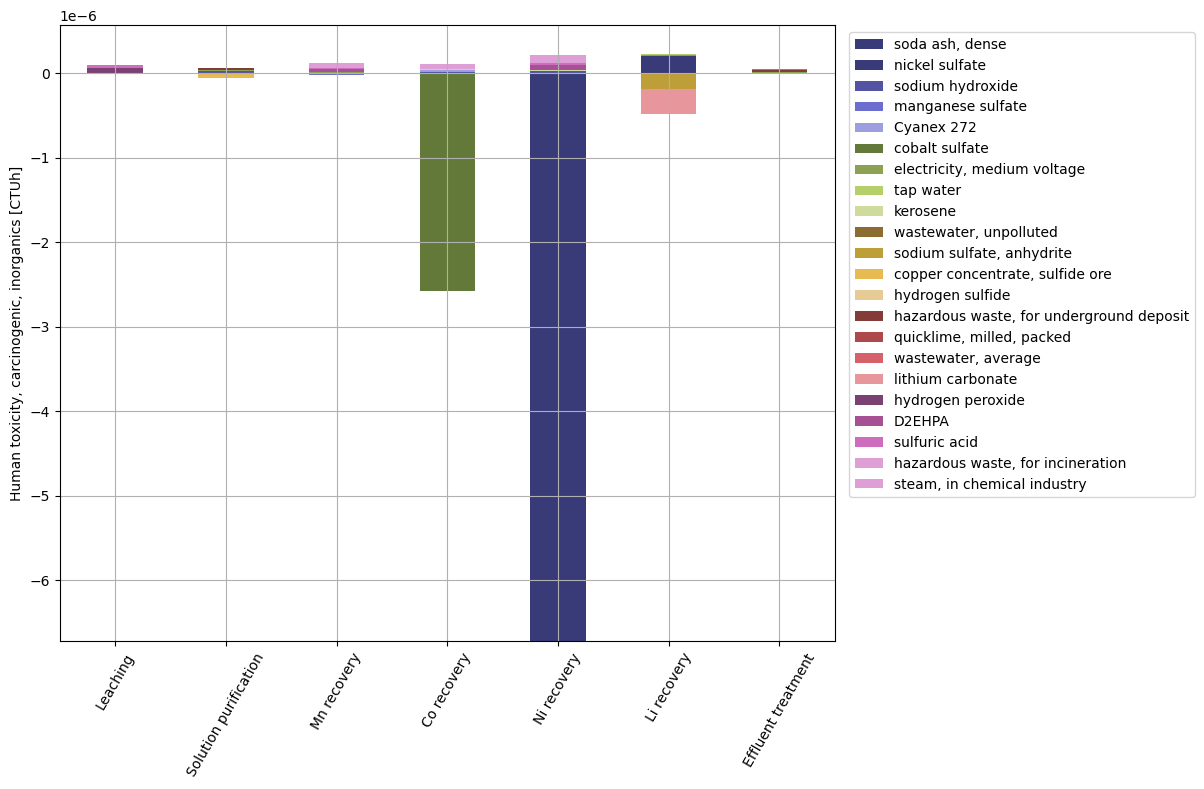

In [21]:
fig, ax = plt.subplots(figsize=(10, 8))

pivot_df.plot.bar(stacked=True, grid=True, ax=ax, cmap=my_cmap)
plt.legend(bbox_to_anchor=(1.01, 1.0))
plt.xlabel('')
plt.xticks(rotation=60)
plt.ylabel(category)
mpl.rcParams.update({'font.size': 16})

plt.show()